In [0]:
#Zhipeng Hong 
#analytic goal: Predict whether user will voted up for a game
#machine learning algorithm : Sentimental,Random Forest

In [0]:
%pip install vaderSentiment

Python interpreter will be restarted.
Collecting vaderSentiment
 Downloading vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
Requirement already satisfied: requests in /databricks/python3/lib/python3.8/site-packages (from vaderSentiment) (2.25.1)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests->vaderSentiment) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests->vaderSentiment) (4.0.0)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests->vaderSentiment) (1.25.11)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests->vaderSentiment) (2.10)
Installing collected packages: vaderSentiment
Successfully installed vaderSentiment-3.3.2
Python interpreter will be restarted.

In [0]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

CPU times: user 72.8 ms, sys: 4.67 ms, total: 77.4 ms
Wall time: 82.2 ms

In [0]:
%%time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def sentimental(x):
    score=analyzer.polarity_scores(x)['compound']
    return score
sentimental_udf=udf(sentimental,FloatType())

CPU times: user 10.7 ms, sys: 3.54 ms, total: 14.3 ms
Wall time: 15.1 ms

In [0]:
%%time
spark = SparkSession.builder.config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")\
                            .config("spark.network.timeout", "36000000000s")\
                            .config("spark.executor.heartbeatInterval", "36000000000s")\
                            .getOrCreate()

CPU times: user 1.58 ms, sys: 606 µs, total: 2.19 ms
Wall time: 4.2 ms

In [0]:
database = 'steam'
collection = 'steam'
user_name = 'jim'
password = 'jim'
address = 'gogogo.chu66.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
%%time
df = spark.read.format("mongo").option("uri",connection_string).load()

CPU times: user 21.1 ms, sys: 1.39 ms, total: 22.5 ms
Wall time: 6.51 s

In [0]:
%%time
def indexStringColumns(df, cols):
    # variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        # For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)
        
        # Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        # and then drops the original columns.
        # and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf
def oneHotEncodeColumns(df, cols):
    newdf = df
    for c in cols:
        ohe = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False)
        ohe_model = ohe.fit(newdf)

        newdf = ohe_model.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 14.5 µs

In [0]:
cols=["appid","platforms","num_games_owned","num_reviews","review",
      "developer","price","publisher","playtime_at_review","playtime_forever",
      "negative_ratings","positive_ratings","voted_up"]
steam=df.select(cols)
# steam=steam.withColumn("game_rating",(steam["positive_ratings"]/(steam["negative_ratings"]+steam["positive_ratings"])))
steam=steam.drop("positive_ratings","negative_ratings")
steam=steam.withColumn("voted_up",steam["voted_up"].cast(IntegerType()))
steam=steam.withColumnRenamed("voted_up","label")
steam=steam.dropna()

In [0]:
# Convert review to sentimental score
steam=steam.withColumn("sentimental_review",sentimental_udf(steam["review"]))
steam=steam.drop("review")

In [0]:
steam.show()

+-----+-----------------+---------------+-----------+--------------------+-----+---------+------------------+----------------+-----+------------------+
appid| platforms|num_games_owned|num_reviews| developer|price|publisher|playtime_at_review|playtime_forever|label|sentimental_review|
+-----+-----------------+---------------+-----------+--------------------+-----+---------+------------------+----------------+-----+------------------+
 730|windows;mac;linux| 3| 2|Valve;Hidden Path...| 0.0| Valve| 11581| 37438| 1| 0.0|
 730|windows;mac;linux| 7| 2|Valve;Hidden Path...| 0.0| Valve| 5344| 8819| 1| 0.7639|
 730|windows;mac;linux| 16| 1|Valve;Hidden Path...| 0.0| Valve| 81075| 161081| 1| -0.5574|
 730|windows;mac;linux| 32| 1|Valve;Hidden Path...| 0.0| Valve| 151849| 243110| 1| 0.5106|
 730|windows;mac;linux| 14| 1|Valve;Hidden Path...| 0.0| Valve| 23220| 37172| 0| -0.8329|
 730|windows;mac;linux| 2| 3|Valve;Hidden Path...| 0.0| Valve| 1644| 33311| 1| 0.7964|
 730|windows;mac;linux| 71| 1|Valve;Hidden Path...| 0.0| Valve| 19581| 41173| 1| 0.0|
 730|windows;mac;linux| 6| 1|Valve;Hidden Path...| 0.0| Valve| 135399| 315836| 1| 0.0|
 730|windows;mac;linux| 1| 1|Valve;Hidden Path...| 0.0| Valve| 6990| 25462| 1| 0.0|
 730|windows;mac;linux| 14| 1|Valve;Hidden Path...| 0.0| Valve| 28942| 64876| 1| 0.765|
 730|windows;mac;linux| 57| 1|Valve;Hidden Path...| 0.0| Valve| 54956| 67188| 0| 0.0772|
 730|windows;mac;linux| 55| 2|Valve;Hidden Path...| 0.0| Valve| 12179| 68053| 0| 0.4404|
 730|windows;mac;linux| 67| 8|Valve;Hidden Path...| 0.0| Valve| 690| 2088| 1| 0.0|
 730|windows;mac;linux| 80| 3|Valve;Hidden Path...| 0.0| Valve| 22454| 35810| 1| 0.7096|
 730|windows;mac;linux| 21| 2|Valve;Hidden Path...| 0.0| Valve| 9243| 23742| 1| 0.8381|
 730|windows;mac;linux| 1| 1|Valve;Hidden Path...| 0.0| Valve| 6692| 7731| 1| 0.0|
 730|windows;mac;linux| 47| 2|Valve;Hidden Path...| 0.0| Valve| 92439| 249440| 0| -0.3597|
 730|windows;mac;linux| 13| 7|Valve;Hidden Path...| 0.0| Valve| 851| 37961| 1| 0.4677|
 730|windows;mac;linux| 3| 3|Valve;Hidden Path...| 0.0| Valve| 2879| 3007| 1| 0.6369|
 730|windows;mac;linux| 23| 2|Valve;Hidden Path...| 0.0| Valve| 51044| 84419| 1| 0.0|
+-----+-----------------+---------------+-----------+--------------------+-----+---------+------------------+----------------+-----+------------------+
only showing top 20 rows

In [0]:
%%time
# Convert String to index
cols=["platforms","developer","publisher"]
steam=indexStringColumns(steam, cols)    

CPU times: user 536 ms, sys: 257 ms, total: 793 ms
Wall time: 3min 20s

In [0]:
# Vector Assembler
inputCols=["appid","num_games_owned","num_reviews","price","playtime_at_review",
           "playtime_forever","sentimental_review","platforms","developer","publisher"]
va = VectorAssembler(outputCol="features", inputCols=inputCols) 
steam_df = va.transform(steam).select("features", "label")

In [0]:
# presistant data into memory
steam_split=steam_df.randomSplit([0.8,0.2])
steam_train = steam_split[0].cache()
steam_valid = steam_split[1].cache()

In [0]:
%%time
# build random forest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rf = RandomForestClassifier()
evaluator = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderPR")
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [10]).addGrid(rf.maxBins, [6000]).addGrid(rf.numTrees,[10,15]).build()

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator, 
                    numFolds=3, 
                    estimatorParamMaps=paramGrid)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 33.7 ms

In [0]:
%%time
# fit the model
cvmodel = cv.fit(steam_train)

CPU times: user 7.86 s, sys: 3.9 s, total: 11.8 s
Wall time: 39min 8s

In [0]:
prediction = cvmodel.bestModel.transform(steam_valid)

In [0]:
tree=cvmodel.bestModel
imp=list(zip(va.getInputCols(), tree.featureImportances))

In [0]:
%%time
print(tree)
print("Best Max Depth : %s" % cvmodel.bestModel.getMaxDepth)
print("Accuracy : %s" % evaluator.evaluate(prediction))

RandomForestClassificationModel: uid=RandomForestClassifier_22ae82f52c7f, numTrees=15, numClasses=2, numFeatures=10
Best Max Depth : <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_22ae82f52c7f, numTrees=15, numClasses=2, numFeatures=10>
Accuracy : 0.9746306598901926
CPU times: user 681 ms, sys: 332 ms, total: 1.01 s
Wall time: 4min 22s

In [0]:
%%time
imp

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Out[21]: [('appid', 0.014684592965797046),
 ('num_games_owned', 0.003106344436133829),
 ('num_reviews', 0.0015161658982960865),
 ('price', 0.06668468729517707),
 ('playtime_at_review', 0.058597310556987824),
 ('playtime_forever', 0.19908643403706833),
 ('sentimental_review', 0.5456099507795332),
 ('platforms', 0.011920668303875533),
 ('developer', 0.07182104543804842),
 ('publisher', 0.02697280028908273)]

In [0]:
imp.sort(key=lambda x:x[1])

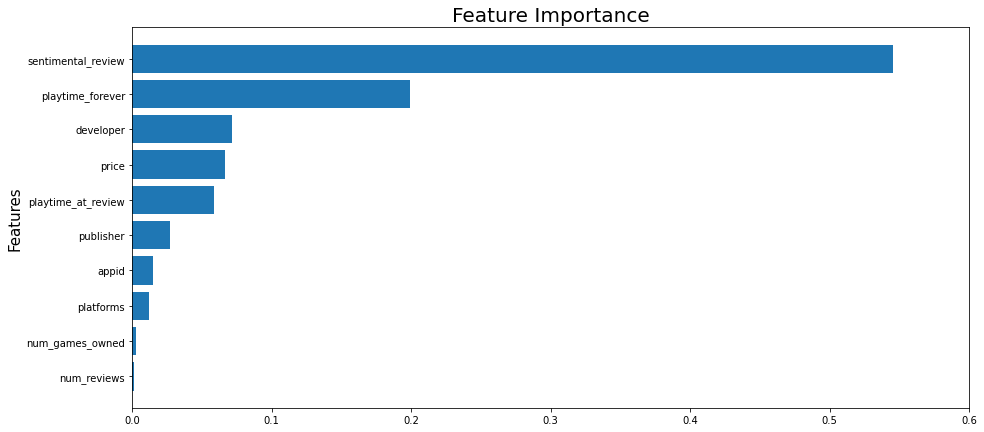

In [0]:
# plot the feature importance
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(15,7))
ax.barh([x[0] for x in imp],[x[1] for x in imp])
ax.set_title("Feature Importance",fontsize=20)
ax.set_ylabel("Features",fontsize=15)
ax.set_xbound(0,0.6)

- The sentimental score of review and the play time is important to predict whether user will vote up a game. 
- Number of games and number of reviews are least important to predict whether user will vote up a game